<>:149: SyntaxWarning: invalid escape sequence '\c'
<>:149: SyntaxWarning: invalid escape sequence '\c'
C:\Users\SAYARI\AppData\Local\Temp\ipykernel_22712\3493411888.py:149: SyntaxWarning: invalid escape sequence '\c'
  file_path ='H:\\APL_files\\bias_field\code_abel\\peak_to_peak_values.csv'


Image size: 1920 × 1080 pixels


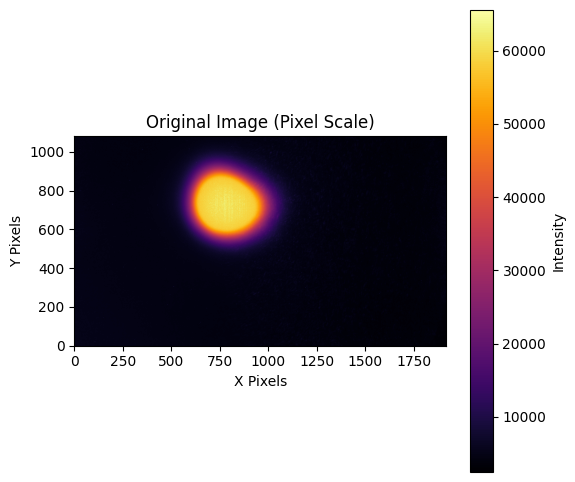

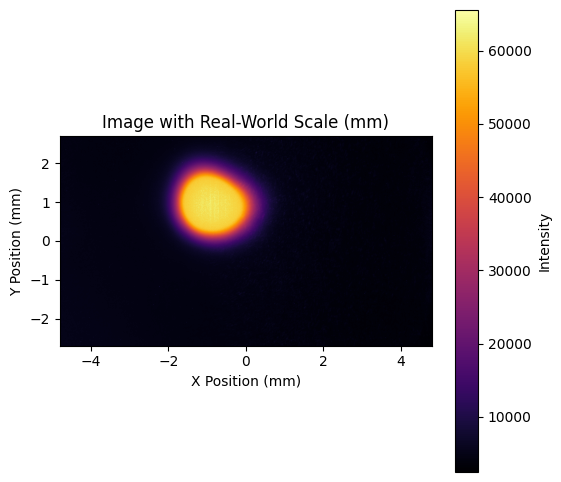

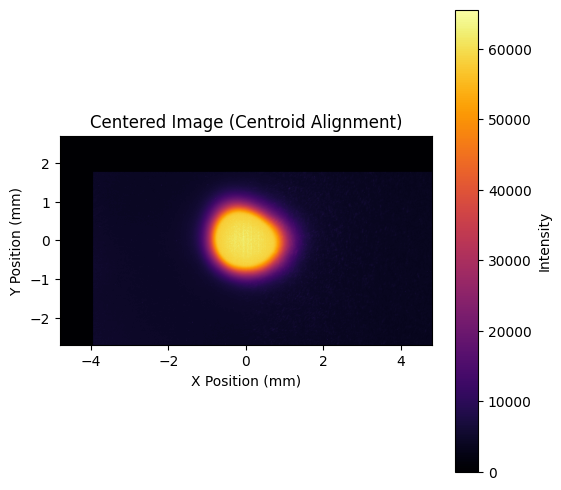

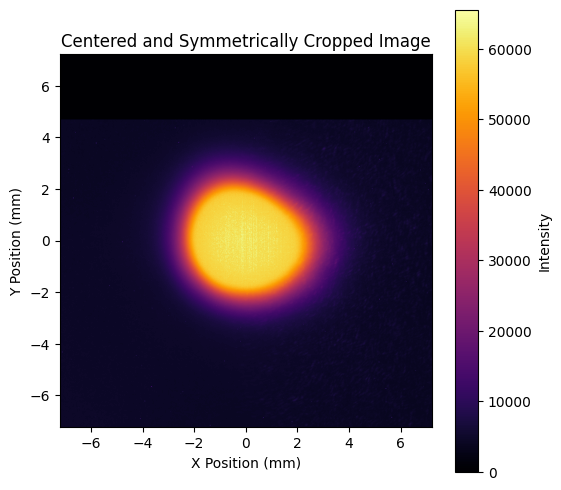

Loading basis sets...
(cropped from basex_basis_960_1.0.npy)
Updating regularization...
Calculating correction...
Using memory-cached basis sets
Using memory-cached basis sets
Using memory-cached basis sets


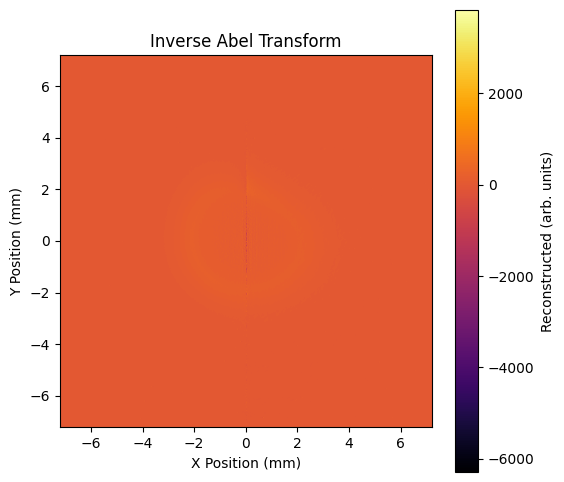

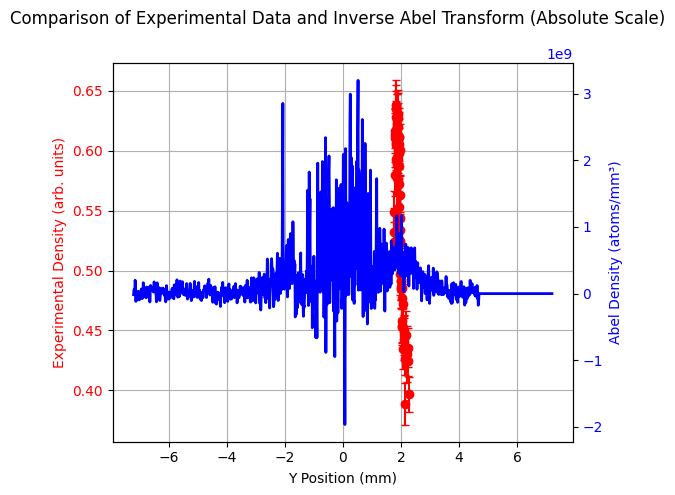

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from abel import Transform
import imageio.v3 as iio
import abel

# Constants
PIXEL_SIZE_UM = 5  # Each pixel is 5 microns
PIXEL_SIZE_MM = PIXEL_SIZE_UM / 1000  # Convert to mm

# Load fluorescence image
image = iio.imread(r"H:\APL_files\bias_field\code_abel\image1_2025-03-24T16-47-50.758.tif")

# Get image size
height, width = image.shape
print(f"Image size: {width} × {height} pixels")

# Define axis limits for conversion to mm
x_extent_mm = width * PIXEL_SIZE_MM / 2
y_extent_mm = height * PIXEL_SIZE_MM / 2

# Plot original image
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap="inferno", origin="lower")
plt.colorbar(label="Intensity")
plt.title("Original Image (Pixel Scale)")
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.show()

# Plot image with real-world coordinates (mm)
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap="inferno", origin="lower",
           extent=[-x_extent_mm, x_extent_mm, -y_extent_mm, y_extent_mm])
plt.colorbar(label="Intensity")
plt.title("Image with Real-World Scale (mm)")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.show()

centered_image = abel.tools.center.center_image(image, method="gaussian")


# Plot centered image
plt.figure(figsize=(6, 6))
plt.imshow(centered_image, cmap="inferno", origin="lower",
           extent=[-x_extent_mm, x_extent_mm, -y_extent_mm, y_extent_mm])
plt.colorbar(label="Intensity")
plt.title("Centered Image (Centroid Alignment)")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.show()
# Constants
DEMAG_FACTOR = 2.67
PIXEL_SIZE_UM = 5  # microns
PIXEL_SIZE_MM = (PIXEL_SIZE_UM * DEMAG_FACTOR) / 1000  # in mm
PIXEL_VOLUME_MM3 = PIXEL_SIZE_MM ** 3


# ================================
# Step 1: Load reconstructed Abel data (already computed)
#         Assuming `reconstructed` and `cropped_image` are defined.
# Get image dimensions
height, width = centered_image.shape

# Find the center coordinates
center_x, center_y = width // 2, height // 2

# Define a symmetric crop size (smallest of half-width and half-height)
crop_size = min(center_x, center_y)

# Ensure cropping does not go out of bounds # Right side positions

x_start = center_x - crop_size
x_end = center_x + crop_size
y_start = center_y - crop_size
y_end = center_y + crop_size

# Perform symmetric cropping
cropped_image = centered_image[y_start:y_end, x_start:x_end]

# Define new extent for correct physical scaling
x_extent_mm = cropped_image.shape[1] * PIXEL_SIZE_MM / 2
y_extent_mm = cropped_image.shape[0] * PIXEL_SIZE_MM / 2

# Plot the cropped image
plt.figure(figsize=(6, 6))
plt.imshow(cropped_image, cmap="inferno", origin="lower",
           extent=[-x_extent_mm, x_extent_mm, -y_extent_mm, y_extent_mm])
plt.colorbar(label="Intensity")
plt.title("Centered and Symmetrically Cropped Image")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.show()


reconstructed = Transform(cropped_image, method='basex', direction='inverse').transform

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(reconstructed, cmap="inferno", origin="lower",
           extent=[-x_extent_mm, x_extent_mm, -y_extent_mm, y_extent_mm])
plt.colorbar(label="Reconstructed (arb. units)")
plt.title("Inverse Abel Transform")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.show()

# ================================

# Define x positions relative to the cloud size
relative_x_positions = [0.0, 0.1,0.2,0.3,0.005] 
# Convert relative positions to pixel indices
x_indices = [int((r + 1) * cropped_image.shape[1] / 2) for r in relative_x_positions]

# Ensure indices are within bounds
x_indices = [max(0, min(idx, cropped_image.shape[1] - 1)) for idx in x_indices]

# Define y positions in mm
y_positions_mm = (np.arange(reconstructed.shape[0]) - reconstructed.shape[0] / 2) * PIXEL_SIZE_MM

# ===================================
# Step 2: Convert Abel transform to physical units (atoms/mm³)
# ===================================

# Total number of atoms (from calibration or estimate)
N_total_atoms = 1e8  # <-- Replace with your actual atom number

# Compute total signal in the reconstructed image
total_abel_signal = reconstructed.sum()

# Compute scale factor: atoms per unit of reconstructed signal
scale_factor = N_total_atoms / total_abel_signal

# Convert to atom density per pixel
density_atoms_per_pixel = reconstructed * scale_factor

# Convert to atoms/mm³
density_atoms_per_mm3 = density_atoms_per_pixel / PIXEL_VOLUME_MM3

# Choose one profile (e.g., at X = 0.54 mm, corresponding to x_indices[1])
abel_density_at_x = density_atoms_per_mm3[:, x_indices[4]]

# ===================================
# Step 3: Load and process experimental data
# ===================================

file_path ='H:\\APL_files\\bias_field\code_abel\\peak_to_peak_values.csv'
df = pd.read_csv(file_path)

# Experimental Y positions (in mm) and densities
y_exp = (df.iloc[:, 0].values)*16*0.005*2.67 + 1.75 # Shift to center around x = 0.54 mm
exp_values = df.iloc[:, 1].values    # Experimental density values
exp_errors = df.iloc[:, 2].values    # Experimental errors (standard deviation)

# Optional: normalize experimental values if needed
# exp_values = (exp_values - np.min(exp_values)) / (np.max(exp_values) - np.min(exp_values))

# ===================================
# Step 4: Plot comparison
# ===================================

fig, ax1 = plt.subplots(figsize=(6, 5))

# Plot experimental data
ax1.errorbar(y_exp, exp_values, yerr=exp_errors, fmt="o", capsize=3, label="Experimental Data", color="red")
ax1.set_xlabel("Y Position (mm)")
ax1.set_ylabel("Experimental Density (arb. units)", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Create second Y-axis for Abel density
ax2 = ax1.twinx()
ax2.plot(y_positions_mm, abel_density_at_x, label="Abel Transform (X=0.54 mm)", color="blue", linewidth=2)
ax2.set_ylabel("Abel Density (atoms/mm³)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
# ax2.set_xlim(1.6, 2.5)
# ax2.set_ylim(0e8,10e8)
# Formatting
fig.suptitle("Comparison of Experimental Data and Inverse Abel Transform (Absolute Scale)")
ax1.grid(True)
fig.tight_layout()

# Show plot
plt.show()

# Save as NumPy binary (.npy)
np.save("abel_density_atoms_per_mm3.npy", density_atoms_per_mm3)

# Save as CSV (with x and y positions)
x_positions_mm = (np.arange(reconstructed.shape[1]) - reconstructed.shape[1] / 2) * PIXEL_SIZE_MM
df_abel = pd.DataFrame(data=density_atoms_per_mm3,
                       index=np.round(y_positions_mm, 6),
                       columns=np.round(x_positions_mm, 6))
df_abel.index.name = "Y (mm)"
df_abel.columns.name = "X (mm)"
df_abel.to_csv("abel_density_atoms_per_mm3.csv")
# Save only the 1D density profile at x_indices[1]
x_pos_mm = x_positions_mm[x_indices[4]]  # Get the corresponding X position in mm
density_profile = density_atoms_per_mm3[:, x_indices[4]]  # 1D profile along Y

# Create DataFrame for saving
df_profile = pd.DataFrame({
    "Y (mm)": y_positions_mm,
    f"Density at X = {x_pos_mm:.3f} mm (atoms/mm³)": density_profile
})

# Save to CSV
df_profile.to_csv(f"abel_density_profile_try_x_{x_pos_mm:.3f}_mm.csv", index=False)



Image size: 1920 × 1080 pixels


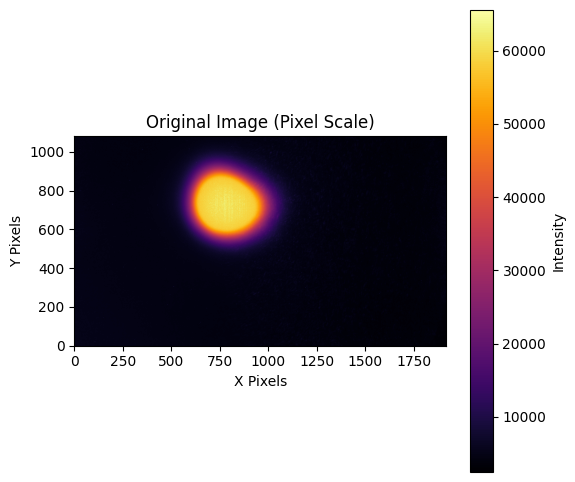

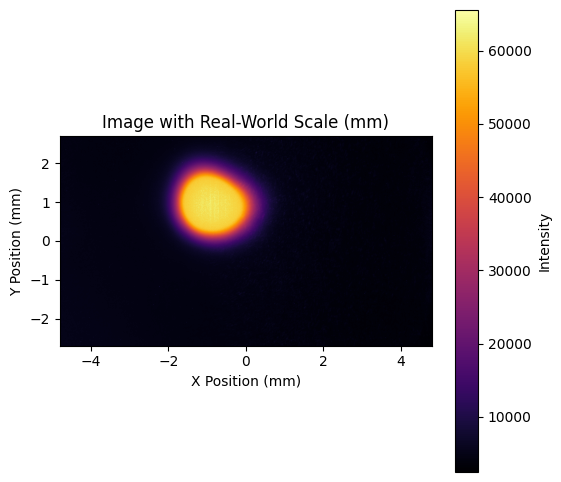

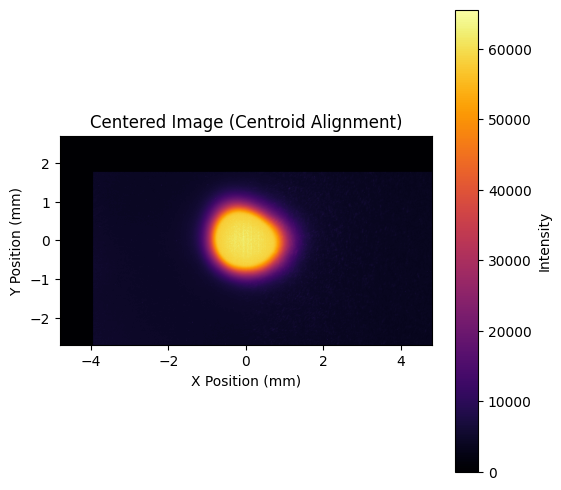

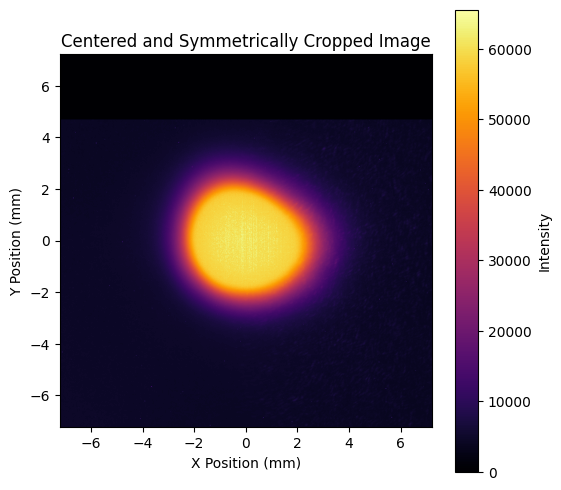

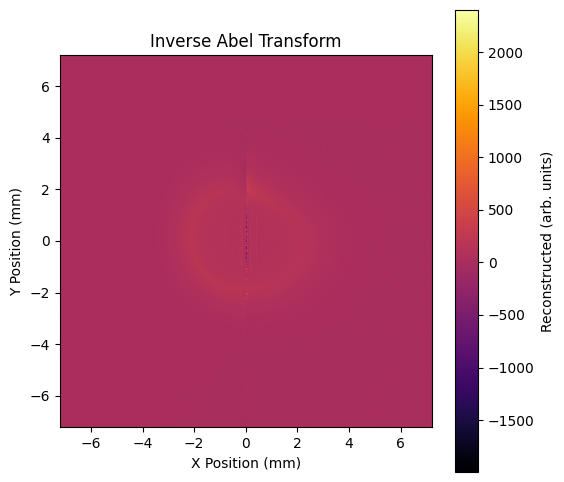

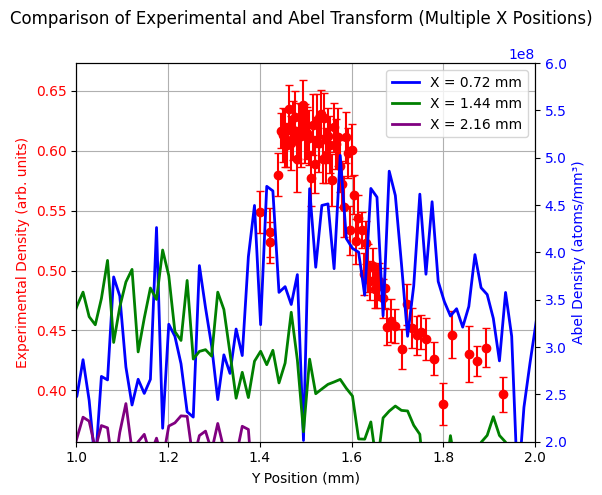

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from abel import Transform
import imageio.v3 as iio
import abel

# Constants
PIXEL_SIZE_UM = 5  # Each pixel is 5 microns
PIXEL_SIZE_MM = PIXEL_SIZE_UM / 1000  # Convert to mm

# Load fluorescence image
image = iio.imread(r"F:\APL_files\bias_field\code_abel\image1_2025-03-24T16-47-50.758.tif")

# Get image size
height, width = image.shape
print(f"Image size: {width} × {height} pixels")

# Define axis limits for conversion to mm
x_extent_mm = width * PIXEL_SIZE_MM / 2
y_extent_mm = height * PIXEL_SIZE_MM / 2

# Plot original image
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap="inferno", origin="lower")
plt.colorbar(label="Intensity")
plt.title("Original Image (Pixel Scale)")
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.show()

# Plot image with real-world coordinates (mm)
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap="inferno", origin="lower",
           extent=[-x_extent_mm, x_extent_mm, -y_extent_mm, y_extent_mm])
plt.colorbar(label="Intensity")
plt.title("Image with Real-World Scale (mm)")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.show()

# Center the image using Gaussian method
centered_image = abel.tools.center.center_image(image, method="gaussian")

# Plot centered image
plt.figure(figsize=(6, 6))
plt.imshow(centered_image, cmap="inferno", origin="lower",
           extent=[-x_extent_mm, x_extent_mm, -y_extent_mm, y_extent_mm])
plt.colorbar(label="Intensity")
plt.title("Centered Image (Centroid Alignment)")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.show()

# Updated constants
DEMAG_FACTOR = 2.67
PIXEL_SIZE_UM = 5  # microns
PIXEL_SIZE_MM = (PIXEL_SIZE_UM * DEMAG_FACTOR) / 1000  # in mm
PIXEL_VOLUME_MM3 = PIXEL_SIZE_MM ** 3

# Crop centered image symmetrically
height, width = centered_image.shape
center_x, center_y = width // 2, height // 2
crop_size = min(center_x, center_y)

x_start = center_x - crop_size
x_end = center_x + crop_size
y_start = center_y - crop_size
y_end = center_y + crop_size

cropped_image = centered_image[y_start:y_end, x_start:x_end]

# Update extents
x_extent_mm = cropped_image.shape[1] * PIXEL_SIZE_MM / 2
y_extent_mm = cropped_image.shape[0] * PIXEL_SIZE_MM / 2

# Plot cropped image
plt.figure(figsize=(6, 6))
plt.imshow(cropped_image, cmap="inferno", origin="lower",
           extent=[-x_extent_mm, x_extent_mm, -y_extent_mm, y_extent_mm])
plt.colorbar(label="Intensity")
plt.title("Centered and Symmetrically Cropped Image")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.show()

# Apply inverse Abel transform
reconstructed = Transform(cropped_image, method='hansenlaw', direction='inverse').transform

# Plot reconstructed
plt.figure(figsize=(6, 6))
plt.imshow(reconstructed, cmap="inferno", origin="lower",
           extent=[-x_extent_mm, x_extent_mm, -y_extent_mm, y_extent_mm])
plt.colorbar(label="Reconstructed (arb. units)")
plt.title("Inverse Abel Transform")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.show()

# Define x positions relative to cloud center
# Define x positions relative to the cloud size
relative_x_positions = [ 0.1,0.2,0.3] 
x_indices = [int((r + 1) * cropped_image.shape[1] / 2) for r in relative_x_positions]
x_indices = [max(0, min(idx, cropped_image.shape[1] - 1)) for idx in x_indices]

# Define physical Y positions
y_positions_mm = (np.arange(reconstructed.shape[0]) - reconstructed.shape[0] / 2) * PIXEL_SIZE_MM

# Convert Abel result to physical units
N_total_atoms = 1e8
total_abel_signal = reconstructed.sum()
scale_factor = N_total_atoms / total_abel_signal
density_atoms_per_pixel = reconstructed * scale_factor
density_atoms_per_mm3 = density_atoms_per_pixel / PIXEL_VOLUME_MM3

# Load experimental data
file_path = 'F:\\APL_files\\bias_field\\code_abel\\peak_to_peak_values.csv'
df = pd.read_csv(file_path)

y_exp = (df.iloc[:, 0].values) * 16 * 0.005 * 2.67 + 1.4
exp_values = df.iloc[:, 1].values
exp_errors = df.iloc[:, 2].values

# Plot comparison of all selected X indices
fig, ax1 = plt.subplots(figsize=(6, 5))

# Experimental plot
ax1.errorbar(y_exp, exp_values, yerr=exp_errors, fmt="o", capsize=3, label="Experimental Data", color="red")
ax1.set_xlabel("Y Position (mm)")
ax1.set_ylabel("Experimental Density (arb. units)", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Abel profiles
ax2 = ax1.twinx()
colors = ["blue", "green", "purple", "orange", "cyan", "magenta"]
x_positions_mm = (np.arange(reconstructed.shape[1]) - reconstructed.shape[1] / 2) * PIXEL_SIZE_MM

for idx, x_idx in enumerate(x_indices):
    abel_profile = density_atoms_per_mm3[:, x_idx]
    x_mm = x_positions_mm[x_idx]
    ax2.plot(y_positions_mm, abel_profile, label=f"X = {x_mm:.2f} mm", color=colors[idx], linewidth=2)

ax2.set_ylabel("Abel Density (atoms/mm³)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.set_ylim(2e8,6e8)
ax2.set_xlim(1,2)
fig.suptitle("Comparison of Experimental and Abel Transform (Multiple X Positions)")
ax1.grid(True)
fig.tight_layout()
ax2.legend(loc="upper right")
plt.show()

# Save full 2D density
np.save("abel_density_atoms_per_mm3.npy", density_atoms_per_mm3)
df_abel = pd.DataFrame(data=density_atoms_per_mm3,
                       index=np.round(y_positions_mm, 6),
                       columns=np.round(x_positions_mm, 6))
df_abel.index.name = "Y (mm)"
df_abel.columns.name = "X (mm)"
df_abel.to_csv("abel_density_atoms_per_mm3.csv")

# Save 1D profiles individually
for idx, x_idx in enumerate(x_indices):
    x_mm = x_positions_mm[x_idx]
    profile = density_atoms_per_mm3[:, x_idx]
    df_profile = pd.DataFrame({
        "Y (mm)": y_positions_mm,
        f"Density at X = {x_mm:.3f} mm (atoms/mm³)": profile
    })
    df_profile.to_csv(f"abel_density_profile_x_{x_mm:.3f}_mm.csv", index=False)


Image size: 1920 × 1080 pixels


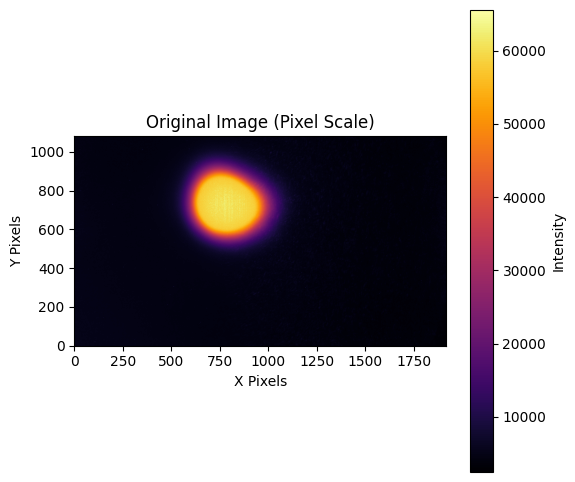

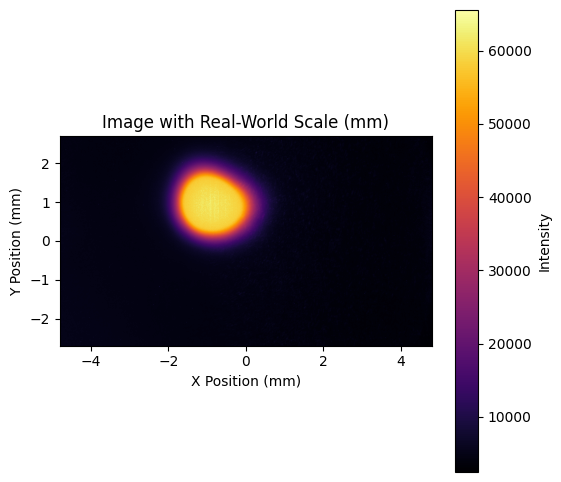

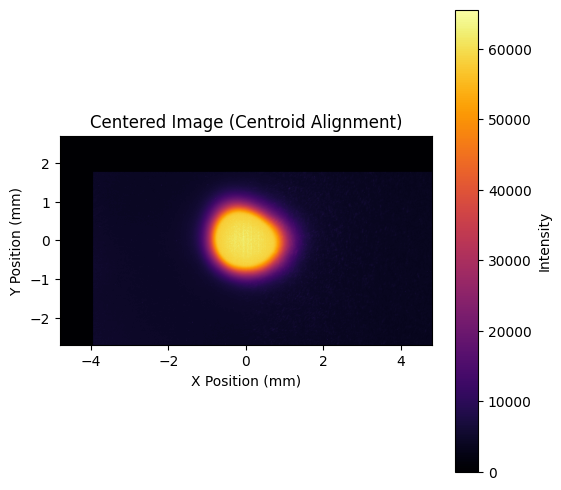

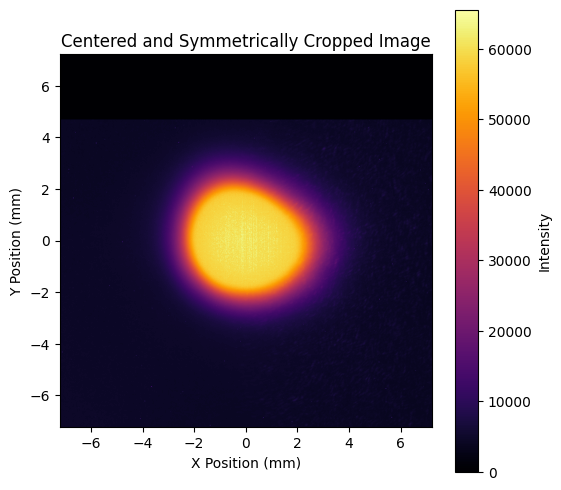

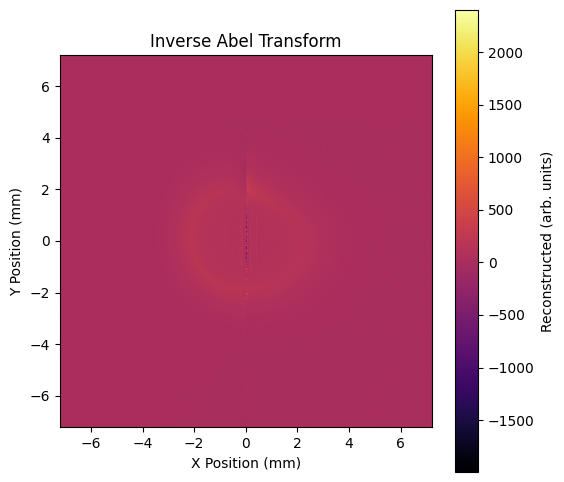

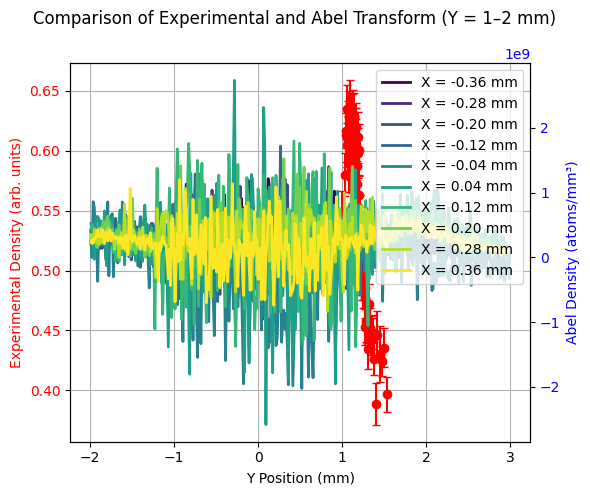

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from abel import Transform
import imageio.v3 as iio
import abel

# Constants
PIXEL_SIZE_UM = 5  # Each pixel is 5 microns
PIXEL_SIZE_MM = PIXEL_SIZE_UM / 1000  # Convert to mm

# Load fluorescence image
image = iio.imread(r"H:\APL_files\bias_field\code_abel\image1_2025-03-24T16-47-50.758.tif")

# Get image size
height, width = image.shape
print(f"Image size: {width} × {height} pixels")

# Define axis limits for conversion to mm
x_extent_mm = width * PIXEL_SIZE_MM / 2
y_extent_mm = height * PIXEL_SIZE_MM / 2

# Plot original image
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap="inferno", origin="lower")
plt.colorbar(label="Intensity")
plt.title("Original Image (Pixel Scale)")
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.show()

# Plot image with real-world coordinates (mm)
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap="inferno", origin="lower",
           extent=[-x_extent_mm, x_extent_mm, -y_extent_mm, y_extent_mm])
plt.colorbar(label="Intensity")
plt.title("Image with Real-World Scale (mm)")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.show()

# Center the image using Gaussian method
centered_image = abel.tools.center.center_image(image, method="gaussian")

# Plot centered image
plt.figure(figsize=(6, 6))
plt.imshow(centered_image, cmap="inferno", origin="lower",
           extent=[-x_extent_mm, x_extent_mm, -y_extent_mm, y_extent_mm])
plt.colorbar(label="Intensity")
plt.title("Centered Image (Centroid Alignment)")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.show()

# Updated constants
DEMAG_FACTOR = 2.67
PIXEL_SIZE_MM = (PIXEL_SIZE_UM * DEMAG_FACTOR) / 1000  # in mm
PIXEL_VOLUME_MM3 = PIXEL_SIZE_MM ** 3

# Crop centered image symmetrically
height, width = centered_image.shape
center_x, center_y = width // 2, height // 2
crop_size = min(center_x, center_y)

x_start = center_x - crop_size
x_end = center_x + crop_size
y_start = center_y - crop_size
y_end = center_y + crop_size

cropped_image = centered_image[y_start:y_end, x_start:x_end]

# Update extents
x_extent_mm = cropped_image.shape[1] * PIXEL_SIZE_MM / 2
y_extent_mm = cropped_image.shape[0] * PIXEL_SIZE_MM / 2

# Plot cropped image
plt.figure(figsize=(6, 6))
plt.imshow(cropped_image, cmap="inferno", origin="lower",
           extent=[-x_extent_mm, x_extent_mm, -y_extent_mm, y_extent_mm])
plt.colorbar(label="Intensity")
plt.title("Centered and Symmetrically Cropped Image")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.show()

# Apply inverse Abel transform
reconstructed = Transform(cropped_image, method='hansenlaw', direction='inverse').transform

# Plot reconstructed
plt.figure(figsize=(6, 6))
plt.imshow(reconstructed, cmap="inferno", origin="lower",
           extent=[-x_extent_mm, x_extent_mm, -y_extent_mm, y_extent_mm])
plt.colorbar(label="Reconstructed (arb. units)")
plt.title("Inverse Abel Transform")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.show()

# Define x positions relative to the cloud size
relative_x_positions = np.linspace(-0.05,0.05,10) 
x_indices = [int((r + 1) * cropped_image.shape[1] / 2) for r in relative_x_positions]
x_indices = [max(0, min(idx, cropped_image.shape[1] - 1)) for idx in x_indices]

# Define physical coordinates
y_positions_mm = (np.arange(reconstructed.shape[0]) - reconstructed.shape[0] / 2) * PIXEL_SIZE_MM
x_positions_mm = (np.arange(reconstructed.shape[1]) - reconstructed.shape[1] / 2) * PIXEL_SIZE_MM

# Convert to density in atoms/mm³
N_total_atoms = 1e8
total_abel_signal = reconstructed.sum()
scale_factor = N_total_atoms / total_abel_signal
density_atoms_per_pixel = reconstructed * scale_factor
density_atoms_per_mm3 = density_atoms_per_pixel / PIXEL_VOLUME_MM3

# Filter for y = 1 mm to 2 mm
y_mask = (y_positions_mm >= -2.0) & (y_positions_mm <= 3.0)
y_positions_mm_filtered = y_positions_mm[y_mask]
density_atoms_filtered = density_atoms_per_mm3[y_mask, :]

# Load experimental data
file_path = 'H:\\APL_files\\bias_field\\code_abel\\peak_to_peak_values.csv'
df = pd.read_csv(file_path)

y_exp = df.iloc[:, 0].values * 16 * 0.005 * 2.67 + 1
exp_values = df.iloc[:, 1].values
exp_errors = df.iloc[:, 2].values

# Filter experimental data for y = 1 to 2 mm
exp_mask = (y_exp >= -2.0) & (y_exp <= 3.0)
y_exp_filtered = y_exp[exp_mask]
exp_values_filtered = exp_values[exp_mask]
exp_errors_filtered = exp_errors[exp_mask]

# Plot comparison
fig, ax1 = plt.subplots(figsize=(6, 5))

# Experimental data
ax1.errorbar(y_exp_filtered, exp_values_filtered, yerr=exp_errors_filtered,
             fmt="o", capsize=3, label="Experimental Data", color="red")
ax1.set_xlabel("Y Position (mm)")
ax1.set_ylabel("Experimental Density (arb. units)", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Abel profiles
ax2 = ax1.twinx()
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, len(x_indices)))

for idx, x_idx in enumerate(x_indices):
    abel_profile = density_atoms_filtered[:, x_idx]
    x_mm = x_positions_mm[x_idx]
    ax2.plot(y_positions_mm_filtered, abel_profile, label=f"X = {x_mm:.2f} mm", color=colors[idx], linewidth=2)

ax2.set_ylabel("Abel Density (atoms/mm³)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

fig.suptitle("Comparison of Experimental and Abel Transform (Y = 1–2 mm)")
ax1.grid(True)
fig.tight_layout()
ax2.legend(loc="upper right")
plt.show()

# Save full 2D density
np.save("abel_density_atoms_per_mm3.npy", density_atoms_per_mm3)
df_abel = pd.DataFrame(data=density_atoms_per_mm3,
                       index=np.round(y_positions_mm, 6),
                       columns=np.round(x_positions_mm, 6))
df_abel.index.name = "Y (mm)"
df_abel.columns.name = "X (mm)"
df_abel.to_csv("abel_density_atoms_per_mm3.csv")

# Save 1D profiles (filtered region only)
for idx, x_idx in enumerate(x_indices):
    x_mm = x_positions_mm[x_idx]
    profile = density_atoms_filtered[:, x_idx]
    df_profile = pd.DataFrame({
        "Y (mm)": y_positions_mm_filtered,
        f"Density at X = {x_mm:.3f} mm (atoms/mm³)": profile
    })
    df_profile.to_csv(f"abel_density_profile_x_{x_mm:.3f}_mm.csv", index=False)


Loaded image with shape: 1920 x 1080 pixels


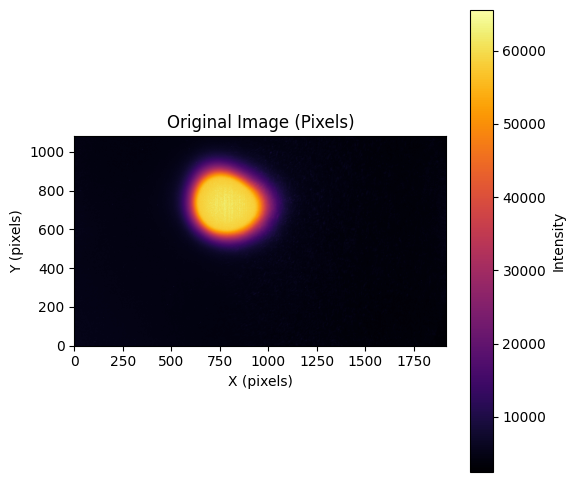

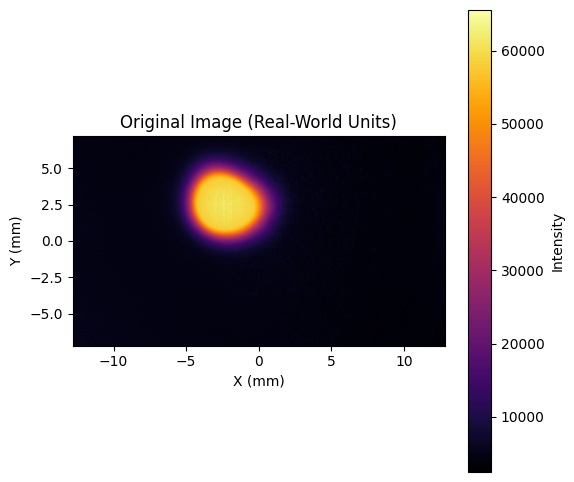

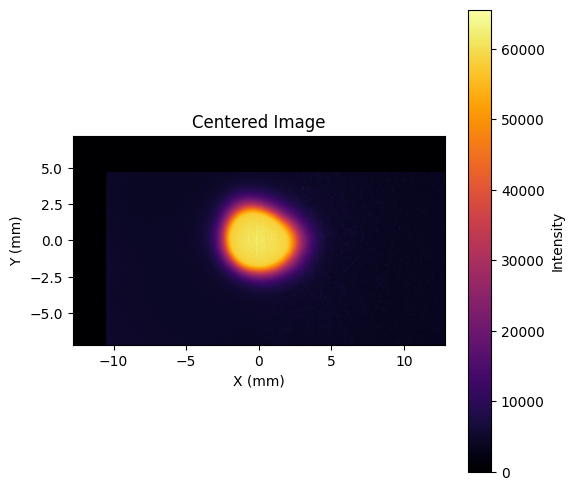

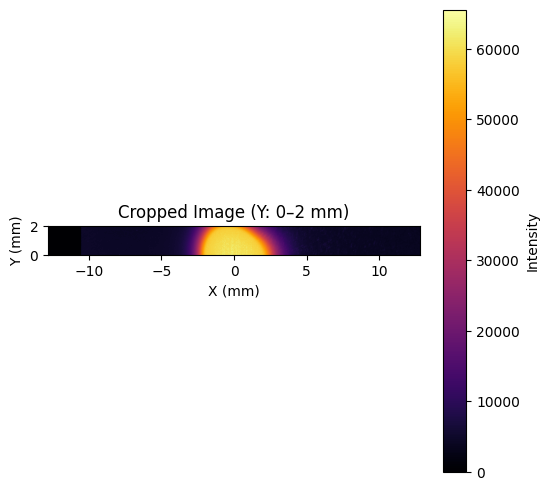

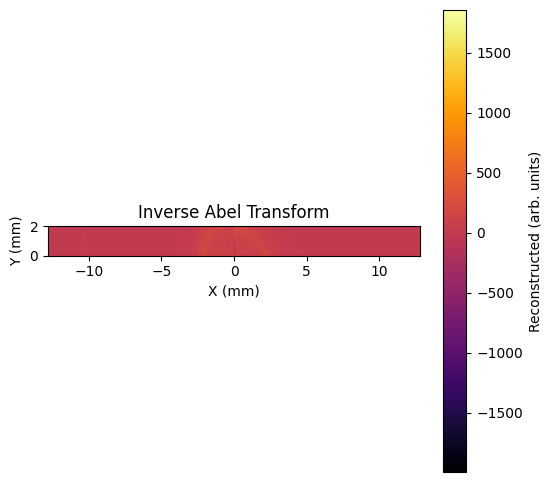

Density data saved as 'atom_density.npy' and 'atom_density.csv'.


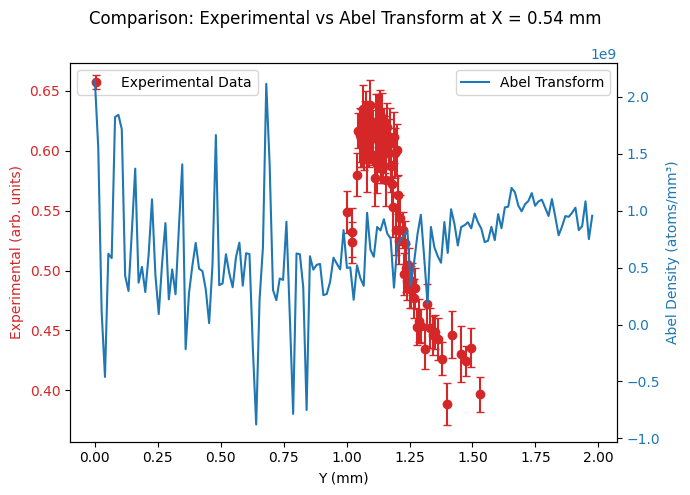

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio
import abel

# ===========================
# Constants and Parameters
# ===========================
DEMAG = 2.67                 # Demagnification factor
PIXEL_SIZE_UM = 5            # Pixel size in micrometers
PIXEL_SIZE_MM = (PIXEL_SIZE_UM * DEMAG) / 1000  # Pixel size in mm
VOLUME_PER_PIXEL_MM3 = PIXEL_SIZE_MM**3
TOTAL_ATOMS = 1e8            # Estimated total atom number

# ===========================
# Load and Display Raw Image
# ===========================
image_path = r"H:\APL_files\bias_field\code_abel\image1_2025-03-24T16-47-50.758.tif"
image = iio.imread(image_path)
height, width = image.shape
print(f"Loaded image with shape: {width} x {height} pixels")

# Plot image in pixel space
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='inferno', origin='lower')
plt.title("Original Image (Pixels)")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label='Intensity')
plt.show()

# Plot image in mm space
x_extent_mm = width * PIXEL_SIZE_MM / 2
y_extent_mm = height * PIXEL_SIZE_MM / 2

plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='inferno', origin='lower',
           extent=[-x_extent_mm, x_extent_mm, -y_extent_mm, y_extent_mm])
plt.title("Original Image (Real-World Units)")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.colorbar(label='Intensity')
plt.show()

# ===========================
# Center Image
# ===========================
centered_img = abel.tools.center.center_image(image, method='gaussian')

plt.figure(figsize=(6, 6))
plt.imshow(centered_img, cmap='inferno', origin='lower',
           extent=[-x_extent_mm, x_extent_mm, -y_extent_mm, y_extent_mm])
plt.title("Centered Image")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.colorbar(label='Intensity')
plt.show()

# ===========================
# Crop Image (Y = 0 to 2 mm)
# ===========================
center_y = height // 2
pixels_per_mm = 1 / PIXEL_SIZE_MM
pixels_crop = int(2 * pixels_per_mm)  # for 2 mm

cropped = centered_img[center_y:center_y + pixels_crop, :]
cropped_extent_y = (cropped.shape[0]) * PIXEL_SIZE_MM

plt.figure(figsize=(6, 6))
plt.imshow(cropped, cmap='inferno', origin='lower',
           extent=[-x_extent_mm, x_extent_mm, 0, 2])
plt.title("Cropped Image (Y: 0–2 mm)")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.colorbar(label='Intensity')
plt.show()

# ===========================
# Inverse Abel Transform
# ===========================
abel_result = abel.Transform(cropped, method='hansenlaw', direction='inverse').transform

plt.figure(figsize=(6, 6))
plt.imshow(abel_result, cmap='inferno', origin='lower',
           extent=[-x_extent_mm, x_extent_mm, 0, 2])
plt.title("Inverse Abel Transform")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.colorbar(label='Reconstructed (arb. units)')
plt.show()

# ===========================
# Calculate Physical Density
# ===========================
scale_factor = TOTAL_ATOMS / abel_result.sum()
density_pixel = abel_result * scale_factor
density_mm3 = density_pixel / VOLUME_PER_PIXEL_MM3

# Save as .npy and .csv
np.save("atom_density.npy", density_mm3)
pd.DataFrame(density_mm3).to_csv("atom_density.csv", index=False)
print("Density data saved as 'atom_density.npy' and 'atom_density.csv'.")

# ===========================
# Load Experimental Data
# ===========================
exp_path = r'H:\APL_files\bias_field\code_abel\peak_to_peak_values.csv'
exp_df = pd.read_csv(exp_path)

# Convert experimental Y to mm using known scaling and shift
y_exp = exp_df.iloc[:, 0].values * 16 * 0.005 * DEMAG + 1
exp_vals = exp_df.iloc[:, 1].values
exp_errs = exp_df.iloc[:, 2].values

# Define real-world axes
x_axis_mm = (np.arange(abel_result.shape[1]) - abel_result.shape[1] // 2) * PIXEL_SIZE_MM
y_axis_mm = np.arange(abel_result.shape[0]) * PIXEL_SIZE_MM

# Get Abel density at X = 0.54 mm
x_target = 0.54
x_idx = np.argmin(np.abs(x_axis_mm - x_target))
abel_line = density_mm3[:, x_idx]

# ===========================
# Plot Comparison
# ===========================
fig, ax1 = plt.subplots(figsize=(7, 5))

# Experimental data
ax1.errorbar(y_exp, exp_vals, yerr=exp_errs, fmt='o', color='tab:red',
             label='Experimental Data', capsize=3)
ax1.set_xlabel("Y (mm)")
ax1.set_ylabel("Experimental (arb. units)", color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Abel result on secondary axis
ax2 = ax1.twinx()
ax2.plot(y_axis_mm, abel_line, '-', color='tab:blue', label='Abel Transform')
ax2.set_ylabel("Abel Density (atoms/mm³)", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Legends and title
fig.suptitle("Comparison: Experimental vs Abel Transform at X = 0.54 mm")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()
